In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchdiffeq import odeint

from pideq.four_tanks import four_tanks
from pideq.net import PIDEQ
from pideq.utils import load_from_wandb

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [22]:
T = 20

net = load_from_wandb(PIDEQ(T, n_states=80), '1g7ayela', model_fname='model_last').to(device)
net.eval

<bound method Module.eval of PIDEQ(
  (B): Linear(in_features=80, out_features=80, bias=True)
  (A): Linear(in_features=1, out_features=80, bias=True)
  (h): Linear(in_features=80, out_features=4, bias=True)
)>

In [18]:
K = 1000
dt = T / K
time = [dt * k for k in range(K+1)]

y0 = torch.Tensor([12.6, 13.0, 4.8, 4.9]).unsqueeze(0)

u = torch.Tensor([3.15, 3.15]).unsqueeze(0)

y = odeint(lambda t, y: four_tanks(y,u), y0, torch.Tensor(time), method='rk4')
y = y.squeeze(1)
y.shape

torch.Size([1001, 4])

In [23]:
x = torch.Tensor(time).unsqueeze(-1).to(device)
# x.requires_grad_()
y_pred = net(x)[0]
# dy_pred_ = torch.autograd.grad(
#     y_pred_.sum(),
#     x
# )[0]

# y_pred = torch.stack([y_pred_, dy_pred_], dim=-1).squeeze(1)
y_pred.shape

torch.Size([1001, 4])

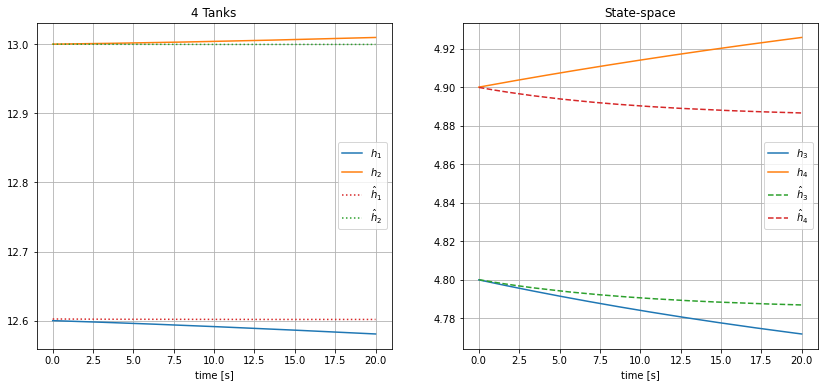

In [24]:
y_ = y.detach().numpy()
y_pred_ = y_pred.cpu().detach().numpy()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,6)

axs[0].set_title('4 Tanks')
axs[0].plot(time, y_[:,0], c='tab:blue', label='$h_1$')
axs[0].plot(time, y_[:,1], c='tab:orange', label='$h_2$')
axs[0].plot(time, y_pred_[:,0], ':', c='tab:red', label='$\hat{h}_1$')
axs[0].plot(time, y_pred_[:,1], ':', c='tab:green', label='$\hat{h}_2$')
axs[0].set_xlabel('time [s]')
axs[0].legend()
axs[0].grid()

axs[1].set_title('State-space')
axs[1].plot(time, y_[:,2], label='$h_3$')
axs[1].plot(time, y_[:,3], label='$h_4$')
axs[1].plot(time, y_pred_[:,2], '--', label='$\hat{h}_3$')
axs[1].plot(time, y_pred_[:,3], '--', label='$\hat{h}_4$')
axs[1].set_xlabel('time [s]')
axs[1].legend()
axs[1].grid()

plt.show()

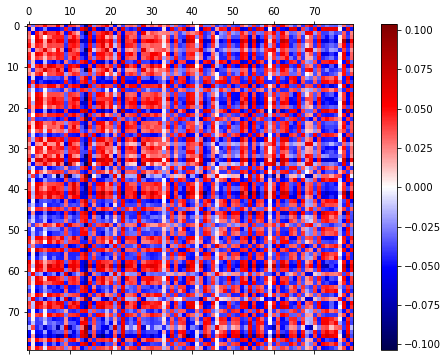

In [25]:
B = net.B.weight.detach().cpu().numpy()
A = net.A.weight.detach().cpu().numpy()

fig, ax = plt.subplots(1,1)

fig.set_size_inches(10,6)

l = max(-B.min(),B.max())
p = ax.matshow(B, cmap='seismic', vmin=-l, vmax=l)
fig.colorbar(p, ax=ax)

# axs[1].matshow(A, cmap='seismic', vmin=-l, vmax=l)

fig.show()

(array([ 2.,  8., 13.,  5., 15., 13., 13.,  6.,  3.,  2.]),
 array([0.49249434, 0.57527316, 0.65805197, 0.74083084, 0.82360965,
        0.90638846, 0.9891673 , 1.0719461 , 1.154725  , 1.2375038 ,
        1.3202826 ], dtype=float32),
 <BarContainer object of 10 artists>)

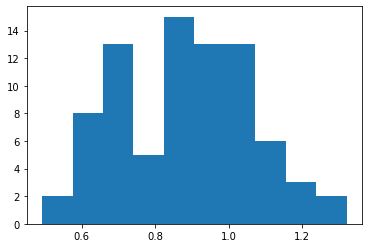

In [26]:
plt.hist(np.abs(A).sum(axis=1))